In [1]:
from copy import deepcopy
import time
import numpy as np
import scipy as sp
import scipy.special
import matplotlib.pyplot as plt

# Approximations to the Maclaurin series expansion

Since the power series has a term,
$$
    \frac{x^n}{n!},
$$
then this term should be calculated together in log-space, using Stirling's approximation,
\begin{align}
    {\rm sign}(x)^n \ln \frac{|x|^n}{n!} \\
    {\rm sign}(x)^n \left( n \ln |x| - \ln n! \right) &\sim {\rm sign}(x)^n \left( n \ln x - \left( \frac{1}{2}\ln(2 \pi n) + n \ln n - n \right) \right) \\
      &\sim {\rm sign}(x)^n \left( n \ln |x| - \left( \frac{1}{2}\ln(2 \pi) + \frac{1}{2}\ln n + n \ln n - n \right) \right) \\
      &\sim {\rm sign}(x)^n \left( n \ln |x| - \left( \frac{1}{2}\ln(2 \pi) + \frac{1}{2}\ln n + n \ln n - n \right) \right) \\
      &\sim {\rm sign}(x)^n \left( n \ln |x| - \frac{1}{2}\ln(2 \pi) - \left( n + \frac{1}{2} \right)\ln n + n \right) \\
\end{align}

Therefore,
$$
    \frac{x^n}{n!} \sim {\rm sign}(x)^n \exp\left( n \ln |x| - \frac{1}{2}\ln(2 \pi) - \left( n + \frac{1}{2} \right)\ln n + n \right)
$$

To further minimize numerical errors, extend operation in log-space to the next level expansion. **There are some issues here with signs that need to be worked out more precisely.**

\begin{align}
    \sum_k a_k x^k &= \sum_k {\rm sign}(x)^k {\rm sign}(a_k) \exp\left( \ln |a_k| + k \ln |x| \right) \\
%
    b_i &= \sum_{k=0}^{\infty} \sum_{\substack{k_0 + k_1 + \cdots + k_i = k \\ 0k_0 + 1k_1 + \cdots + i k_i = i}} s_k \theta^k \binom{k}{k_0, k_1, \ldots, k_i} \prod_{n=0}^{\infty} a_n^{k_n} \\
    \ln b_i &= \ln\left( \sum_{k=0}^{\infty} \sum_{\substack{k_0 + k_1 + \cdots + k_i = k \\ 0k_0 + 1k_1 + \cdots + i k_i = i}} s_k \theta^k \binom{k}{k_0, k_1, \ldots, k_i} \prod_{n=0}^{\infty} a_n^{k_n} \right) \\
      &= \ln\left( s_{\rm max} \left( \theta^k \right)_{\rm max} \binom{k}{k_0, k_1, \ldots, k_i}_{\rm max} \prod_{n=0}^\infty \left( a_n^{k_n} \right)_{\rm max} \right) + \\
      &\phantom{=} + \ln\left( \sum_{k=0}^{\infty} \sum_{\substack{k_0 + k_1 + \cdots + k_i = k \\ 0k_0 + 1k_1 + \cdots + i k_i = i}} \frac{s_k}{s_{\rm max}} \frac{\theta^k}{\left( \theta^k \right)_{\rm max}} \frac{\binom{k}{k_0, k_1, \ldots, k_i}}{\binom{k}{k_0, k_1, \ldots, k_i}_{\rm max}} \prod_{n=0}^{\infty} \frac{a_n^{k_n}}{\left( a_n^{k_n} \right)_{\rm max}} \right)
\end{align}

In [2]:
class Maclaurin:
    def __init__(self, order=None):
        self._coeff = []
        # TODO: add cache for largest order
        self.set_order(order)
        
    def __call__(self, x):
        """Evaluates the series at a point, x"""
        n = np.arange(len(self._coeff))
        coeff = self.coeff
        x = np.asarray(x)
        try:
            # if x is an array of values
            bases = np.apply_over_axes(lambda x, a: x**n, x[:, np.newaxis], -1)
        except IndexError:
            # if x is a single value
            bases = x**n
        return bases@coeff
    
    def copy(self, rhs):
        self._coeff = deepcopy(rhs._coeff)
        return self
    
    @property
    def coeff(self):
        """Returns the coefficients as a numpy array."""
        return np.asarray(self._coeff)
    
    def _coeff_generating_function(self, order):
        """Generates coefficients of the power series out to `order`."""
        raise NotImplementedError("`_coeff_generating_function` must be defined "
                                  "in derived class.")
    
    def set_order(self, order):
        if order is None:
            del self._coeff
            self._coeff = []
        else:
            try:
                self._coeff_generating_function(order)
            except NotImplementedError:
                self._coeff = np.zeros(order+1)


class Sine(Maclaurin):
    def __call__(self, x):
        """
        This does not handle vector x and vector n! Fix! Also,
        this doesn't help apply the function several times...
        """
        def log_xn(x, n):
            return (np.sign(x))**n * n * np.log(np.abs(x))
            
        def log_factorial(n):
            if n < 10:
                return np.log(scipy.special.factorial(n))
            else:
                return 0.5*np.log(2*np.pi) + (n + 0.5)*np.log(n) - n
            
        order = len(self._coeff)
        n = np.arange(order)[1::2]
        sign = (-1)**(n//2)
        try:
            # if x is an array of values
            terms = np.apply_over_axes(
                lambda x, a: np.exp(log_xn(x, n) - log_factorial(n)),
                x[:, np.newaxis], -1)
        except IndexError:
            # if x is a single value
            terms = np.exp(log_xn(x, n) - log_factorial(n))
        return bases@sign
        
    def _coeff_generating_function(self, order):
        order += 1  # add the 0th-order term
        coeff = np.zeros(order)
        n = np.arange(order)[1::2]
        coeff[1::2] = (-1)**(n//2)/scipy.special.factorial(n)
        self._coeff = coeff
        return self
    

class Linear(Maclaurin):
    def __init__(self, order=None, offset=0, slope=1):
        super().__init__()
        self._offset = offset
        self._slope = slope
        self.set_order(order)
        
    def _coeff_generating_function(self, order):
        coeff = np.zeros(order+1)
        coeff[0] = self._offset
        coeff[1] = self._slope
        self._coeff = coeff
        return self

# First, we set up the definitions for the power series of our activation functions.
# def half_maclaurin(n):
#     for i in range(n + 1):
#         if i == 1:
#             yield 0.5
#         else:
#             yield 0.0
            
# def sine_maclaurin(n):
#     fact = 1.0
#     for i in range(n + 1):
#         if i > 0:
#             fact = fact / i
        
#         if i % 2 == 0:
#             yield 0.0
#         else:
#             yield (-1)**(i // 2) * fact

functions = [
    (np.sin, Sine(), "Sine"),
    (lambda x: 0.5 * x, Linear(offset=0, slope=0.5), "Half")
]

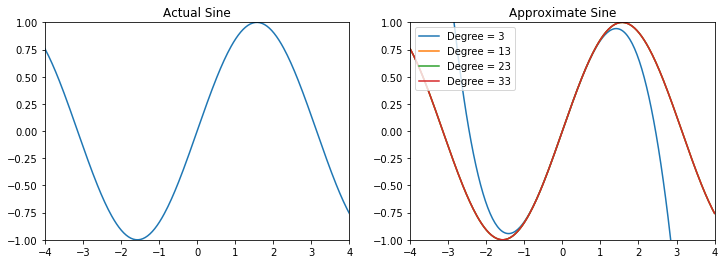

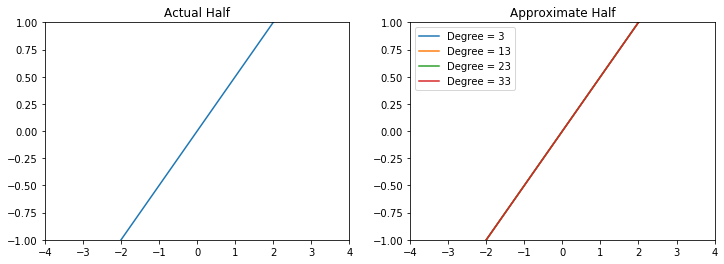

In [3]:
# Second, we check that the power series expansions are correct by simply plotting actual versus approximate.
degrees = [3, 13, 23, 33]

for fn, gfn, name in functions:
    x = np.linspace(-4.0, 4.0, 256)
    y = fn(x)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    axes[0].plot(x, y)
    axes[0].set_xlim(-4.0, 4.0)
    axes[0].set_ylim(-1.0, 1.0)
    axes[0].set_title(f"Actual {name}")

    for d in degrees:
        gfn.set_order(d)
#         coeffs = list(gfn(d))
#         z = np.zeros_like(x)
#         for n, c in enumerate(coeffs):
#             z = z + (c * np.power(x, n))
        z = gfn(x)

        axes[1].plot(x, z, label=f"Degree = {d}")
    axes[1].set_xlim(-4.0, 4.0)
    axes[1].set_ylim(-1.0, 1.0)
    axes[1].set_title(f"Approximate {name}")
    axes[1].legend()
    
    plt.show()

In [4]:
def cached(opt):
    """Whether to cache a function or not."""
    def _cached(func):
        def astuple(x):
            try:
                return tuple(x)
            except TypeError:
                return (x,)

        _cache = {}
        def f(*args):
            key = tuple(astuple(a) for a in args)
            try:
                return _cache[key]
            except KeyError:
                result = func(*args)
                _cache[key] = result
                return result
        return f

    def _uncached(func):
        def f(*args):
            return func(*args)
        return f
    
    return _cached if opt else _uncached

# Third, we check the errors in the scalar case.
# Note: s_n is n-th coefficient in power series of function.
#       a_n is n-th coefficient in power series of variable.
# The following solves for the new coefficients in a power series transformation.
def solve_icoeff(s, a, i):
    """Solve for the i-th coefficient in the new power series of $s(x)$.
    Arguments:
    s -- coefficients of power series of function.
    a -- coefficients of power series of variable.
    i -- the index of the coefficient to obtain.
    """
    @cached(False)
    def index_constraint(k_array, k):
        """k_0 + k_1 + ... + k_i = k"""
        return (k == np.sum(k_array))

    @cached(False)
    def power_constraint(k_array, k):
        """0*k_0 + 1*k_1 + ... + i*k_i + ... = k"""
        return (k == np.sum(np.arange(len(k_array))*k_array))
    
    def candidate_ks(k_array, k):
        if k == 0:
            for i in range(len(k_array)):
                k_array[i] = 0
            yield k_array
        elif len(k_array) == 1:
            k_array[0] = k
            yield k_array
        else:
            for j in range(0, k + 1):
                k_array[0] = j
                for solns in candidate_ks(k_array[1:], k - j):
                    yield k_array

    @cached(True)
    def multinomial(k_array):
        if len(k_array) == 1:
            return 1
        else:
            return sp.special.binom(sum(k_array), k_array[-1]) * multinomial(k_array[:-1])
    
    coeff = 0.0
    for k in range(len(s)):
        k_array = np.zeros_like(a, dtype=int)
        for k_soln in candidate_ks(k_array, k):
            # Check if constraints are satisfied.
            # Then, add the appropriate term.
            # BK: 8 Mar 2020, There was no check on the index constraint. I added this.
            if (power_constraint(k_soln, i) and index_constraint(k_soln, k)):
#                 prod = 1.0
#                 for d in range(len(a)):
#                     prod *= np.power(a[d], k_soln[d])
                prod = np.prod(a**k_soln)
                coeff += s[k] * multinomial(k_soln) * prod
                    
    return coeff

-------- Sine --------


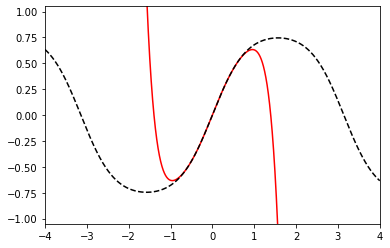

N=8,	 D=8,	 Depth=3:	 Error=1526.363060025546,	 Time=2.08750200


<Figure size 432x288 with 0 Axes>

N=8,	 D=16,	 Depth=3:	 Error=2787470.463527395390,	 Time=182.36578894


KeyboardInterrupt: 

In [5]:
x, dx = np.linspace(-4.0, 4.0, num=8192, retstep=True)

func_degrees = [8, 16, 32]
var_degrees = [8, 16, 32]
# depths = [1, 2, 3]
depths = [3]

runtimes = []

class Solution:
    def __init__(self, soln, err):
        self.solution = soln
        self.error = err
solutions = {}
fig, ax = plt.subplots(1,1)
for fn, gfn, name in functions:
    print(f"{'-'*8} {name} {'-'*8}")
    for func_d in func_degrees:
        # Create Maclaurin series coefficients.
#         s = np.array(list(gfn(func_d)))
        gfn.set_order(func_d)
        s = gfn.coeff
        
        for var_d in var_degrees:
            # Intialize approximation.
#             y = x
#             b = np.zeros(var_d + 1)
#             b[1] = 1.0

            for depth in depths:
                y = x
                soln = Linear(var_d)
                b = soln.coeff
                for _ in range(depth):
                    # Calculate actual function approximation.
                    y = fn(y)
                    
                    # Perform the transformation.
#                     c = np.zeros_like(b)
                    start = time.time()
                    c = [solve_icoeff(s, b, i) for i in range(len(b))]
                    end = time.time()
                    b = np.asarray(c)
                    elapsed = end - start

                # Get the power series estimation.
                soln._coeff = b
                z = soln(x)
#                 z = np.zeros_like(x)
#                 for i in range(var_d + 1):
#                     z = z + (b[i] * np.power(x, i))

                # Find the error in the approximation.
                error = np.sqrt(dx * np.sum(np.power(y - z, 2.0)))
                
                # save and report the results
                key = (func_d, var_d, depth)
                solutions[key] = Solution(soln, error)
                ax.cla();
                ax.plot(x, z, 'r-');
                ax.plot(x, y, 'k--');
                ax.set_xlim(x.min(), x.max());
                ax.set_ylim(-1.05, 1.05);
                plt.draw();
                plt.show();
                print(f"N={func_d},\t D={var_d},\t Depth={depth}:\t Error={error:17.12f},\t Time={elapsed:.8f}")
                time.sleep(2.5)

In [ ]:
x, dx = np.linspace(-4.0, 4.0, num=8192, retstep=True)

func_degrees = [1, 3, 5, 9, 11]
var_degrees = [5, 7, 9, 11]
depths = [1, 2, 3]

runtimes = []

for fn, gfn, name in functions:
    print(f"{'-'*8}{name}{'-'*8}")
    for func_d in func_degrees:
        # Create Maclaurin series coefficients.
        s = np.array(list(gfn(func_d)))
        
        for var_d in var_degrees:
            # Intialize approximation.
            y = x
            b = np.zeros(var_d + 1)
            b[1] = 1.0

            for depth in depths:
                # Calculate actual function approximation.
                y = fn(y)

                # Perform the transformation.
                c = np.zeros_like(b)
                start = time.time()
                for i in range(var_d + 1):
                    c[i] = solve_icoeff(s, b, i)
                end = time.time()
                b = c
                elapsed = end - start

                # Get the power series estimation.
                z = np.zeros_like(x)
                for i in range(var_d + 1):
                    z = z + (b[i] * np.power(x, i))

                fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
                    
                axes[0].plot(x, y)
                axes[0].set_xlim(-4.0, 4.0)
                axes[0].set_ylim(-1.0, 1.0)
                axes[0].set_title(f"Actual {name}")

                axes[1].plot(x, z)
                axes[1].set_xlim(-4.0, 4.0)
                axes[1].set_ylim(-1.0, 1.0)
                axes[1].set_title(f"Approximate {name}")
                
                plt.show()
                    
                # Find the error in the approximation.
                error = np.sqrt(dx * np.sum(np.power(y - z, 2.0)))

                print(f"N={func_d},\t D={var_d},\t Depth={depth}:\t Error={error:17.12f},\t Time={elapsed:.8f}")
            